# trying kaggle stuff

In [8]:
!pip install mlcroissant

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/569.0 kB ? eta -:--:--
   ---------------------------------------- 569.0/569.0 kB 7.3 MB/s  0:00:00
  Created wheel for jsonpath-rw: filename=jsonpath_rw-1.4.0-py3-none-any.whl size=15234 sha256=8fecaed10b972412acaeb0bdce16584e149c796f610894d7884c70e02ff7bf0f
  Stored in directory: c:\users\muham\appdata\local\pip\cache\wheels\e5\6b\25\0e13e900c59946c4724aa54c1add9033d803112090b76768ee
Successfully built jsonpath-rw

   ----- ---------------------------------- 1/8 [rdflib]
   ----- ---------------------------------- 1/8 [rdflib]
   ----- ---------------------------------- 1/8 [rdflib]
   ----- ---------------------

In [11]:
import mlcroissant as mlc
import itertools

In [19]:
import os
from pathlib import Path

import kagglehub
import matplotlib.pyplot as plt
import mlcroissant as mlc
import pandas as pd
from IPython.display import display

CROISSANT_URL = "https://www.kaggle.com/datasets/kushagraarya10/cia-global-statistical-database/croissant/download"

croissant_dataset = mlc.Dataset(CROISSANT_URL)
record_set_ids = [record.id for record in croissant_dataset.metadata.record_sets]
record_sets_by_id = {record.id: record for record in croissant_dataset.metadata.record_sets}

print("Available record sets:")
for record_id in record_set_ids:
    print(f" - {record_id}")

DATASET_DIR = Path(kagglehub.dataset_download("kushagraarya10/cia-global-statistical-database"))
print(f"Downloaded dataset directory: {DATASET_DIR}")

  -  [Metadata(CIA Global Statistical Database)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.
  -  [Metadata(CIA Global Statistical Database)] Property "https://schema.org/version" is recommended, but does not exist.


Available record sets:
 - communications_data.csv
 - demographics_data.csv
 - economy_data.csv
 - energy_data.csv
 - geography_data.csv
 - government_and_civics_data.csv
 - transportation_data.csv


100%|██████████| 54.7k/54.7k [00:00<00:00, 459kB/s]

Extracting files...
Downloaded dataset directory: C:\Users\muham\.cache\kagglehub\datasets\kushagraarya10\cia-global-statistical-database\versions\4


In [22]:
from mlcroissant import GenerationError


def _decode_bytes(df: pd.DataFrame) -> pd.DataFrame:
    for column in df.columns:
        if df[column].dtype == object:
            df[column] = df[column].apply(
                lambda value: value.decode("utf-8", errors="ignore")
                if isinstance(value, (bytes, bytearray))
                else value
            )
    return df


def _coerce_numeric_columns(df: pd.DataFrame) -> pd.DataFrame:
    for column in df.columns:
        if df[column].dtype == object:
            cleaned = pd.to_numeric(
                df[column]
                .astype(str)
                .str.replace(",", "", regex=False)
                .str.replace("\u202f", "", regex=False),
                errors="coerce",
            )
            if cleaned.notna().sum() >= len(cleaned) * 0.8:
                df[column] = cleaned
    return df


def record_to_dataframe(dataset: mlc.Dataset, record_id: str) -> pd.DataFrame:
    """Load a record set into a pandas DataFrame."""
    try:
        rows = list(dataset.records(record_set=record_id))
        if not rows:
            return pd.DataFrame()
        if isinstance(rows[0], dict):
            df = pd.DataFrame(rows)
        else:
            field_names = [field.name for field in record_sets_by_id[record_id].fields]
            df = pd.DataFrame(rows, columns=field_names)
    except GenerationError as err:
        fallback_path = DATASET_DIR / record_id
        print(
            f"Croissant stream failed for {record_id} (reason: {err}). Using pandas.read_csv instead."
        )
        df = pd.read_csv(fallback_path, thousands=",", dtype_backend="numpy_nullable")

    df = _decode_bytes(df)
    df = _coerce_numeric_columns(df)
    return df


def show_dataframe_summary(df: pd.DataFrame, title: str, max_hist_cols: int = 4) -> None:
    print(f"{title} — shape: {df.shape}")
    display(df.head())

    numeric_cols = df.select_dtypes(include="number").columns.tolist()
    if not numeric_cols:
        print("fuck No numeric columns available for visualization.")
        return

    cols_to_plot = numeric_cols[:max_hist_cols]
    axes = df[cols_to_plot].hist(bins=20, figsize=(4 * len(cols_to_plot), 4))
    plt.suptitle(f"{title}: distributions for {', '.join(cols_to_plot)}", fontsize=14)
    plt.tight_layout()
    plt.show()


communications_data.csv — shape: (259, 6)


,communications_data.csv/Country,communications_data.csv/telephone_fixed_subscriptions_total,communications_data.csv/mobile_cellular_subscriptions_total,communications_data.csv/internet_country_code,communications_data.csv/internet_users_total,communications_data.csv/broadband_fixed_subscriptions_total
0,AFGHANISTAN,150000.0,23000000.0,.af,7020000.0,26570.0
1,AKROTIRI,NaN,NaN,None,NaN,NaN
2,ALBANIA,197690.0,2635466.0,.al,2291000.0,508937.0
3,ALGERIA,5097095.0,47028685.0,.dz,31240000.0,3790459.0
4,AMERICAN SAMOA,10000.0,2250.0,.as,18135.0,NaN


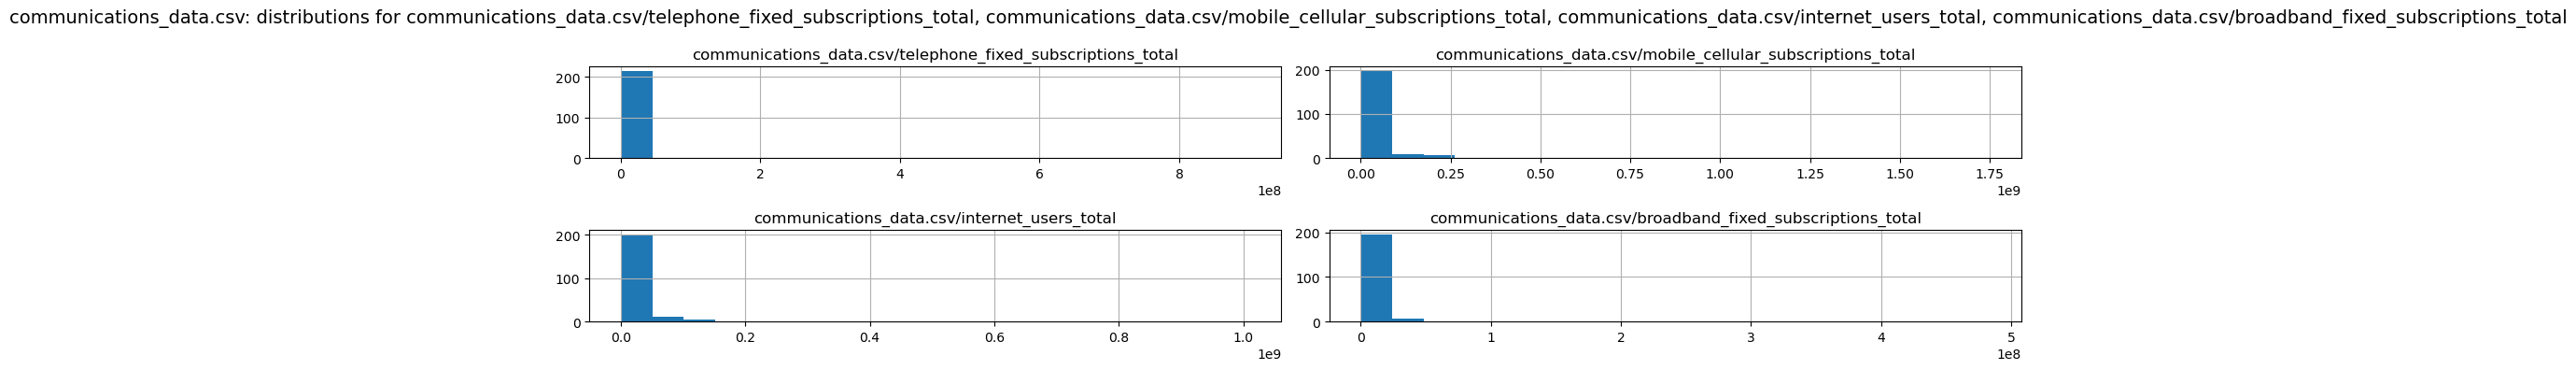

Croissant stream failed for demographics_data.csv (reason: An error occured during the streaming generation of the dataset, more specifically during the operation Read(demographics_data.csv_fileobject)). Using pandas.read_csv instead.
demographics_data.csv — shape: (259, 14)


,Country,Total_Population,Population_Growth_Rate,Birth_Rate,Death_Rate,Net_Migration_Rate,Median_Age,Sex_Ratio,Infant_Mortality_Rate,Total_Fertility_Rate,Total_Literacy_Rate,Male_Literacy_Rate,Female_Literacy_Rate,Youth_Unemployment_Rate
0,AFGHANISTAN,39232003,2.26%,34.79,12.08,0.1,19.5,1.02,103.06,4.53,37.3%,39.4%,7.2%,20.2%
1,AKROTIRI,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,ALBANIA,3101621,0.19%,12.48,7.36,3.22,34.3,0.97,10.54,1.55,98.4%,38.8%,6%,27.8%
3,ALGERIA,44758398,1.27%,17.84,4.33,0.81,28.9,1.03,19.22,2.47,81.4%,41.3%,0.7%,31.9%
4,AMERICAN SAMOA,44620,1.74%,16.18,6.19,27.36,27.2,0.99,9.87,2.13,<NA>,<NA>,<NA>,<NA>


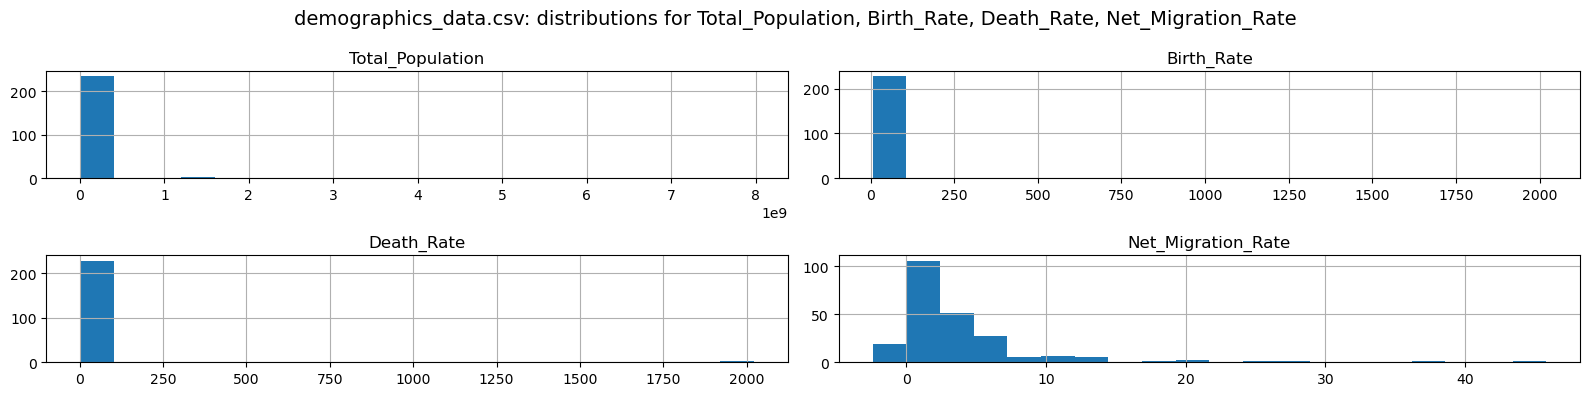

economy_data.csv — shape: (259, 16)


,economy_data.csv/Country,economy_data.csv/Real_GDP_PPP_billion_USD,economy_data.csv/GDP_Official_Exchange_Rate_billion_USD,economy_data.csv/Real_GDP_Growth_Rate_percent,economy_data.csv/Real_GDP_per_Capita_USD,economy_data.csv/Unemployment_Rate_percent,economy_data.csv/Youth_Unemployment_Rate_percent,economy_data.csv/Budget_billion_USD,economy_data.csv/Budget_Surplus_billion_USD,economy_data.csv/Budget_Deficit_percent_of_GDP,economy_data.csv/Public_Debt_percent_of_GDP,economy_data.csv/Fiscal_Year,economy_data.csv/Exports_billion_USD,economy_data.csv/Imports_billion_USD,economy_data.csv/Exchange_Rate_per_USD,economy_data.csv/Population_Below_Poverty_Line_percent
0,AFGHANISTAN,60.80,20.24,-20.74,1500.0,13.28,20.2,5.09,15.1,-15.1,7.00,21 March - 20 March,1.48,6.98,76.814,54.5
1,AKROTIRI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
2,ALBANIA,40.82,15.27,8.52,14500.0,11.82,27.8,4.19,2.0,-2.0,84.06,calendar year,5.61,8.00,103.520,14.3
3,ALGERIA,487.72,169.91,3.50,11000.0,12.70,31.9,55.19,9.6,-9.6,27.50,calendar year,41.78,44.32,135.064,5.5
4,AMERICAN SAMOA,658.00,658.00,-1.87,11200.0,29.80,NaN,249.00,2.1,-2.1,12.20,1 October - 30 September,428.00,615.00,NaN,NaN


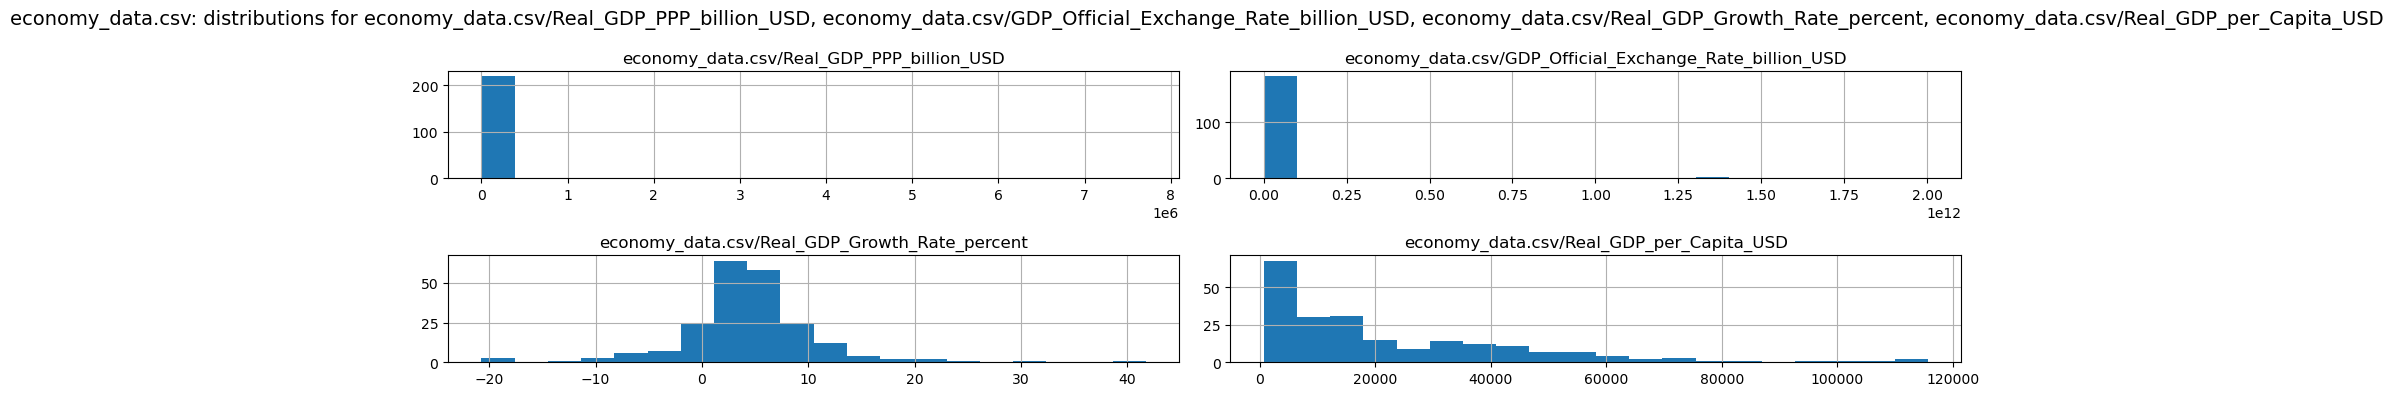

energy_data.csv — shape: (259, 10)


,energy_data.csv/Country,energy_data.csv/electricity_access_percent,energy_data.csv/electricity_generating_capacity_kW,energy_data.csv/coal_metric_tons,energy_data.csv/petroleum_bbl_per_day,energy_data.csv/refined_petroleum_products_bbl_per_day,energy_data.csv/refined_petroleum_exports_bbl_per_day,energy_data.csv/refined_petroleum_imports_bbl_per_day,energy_data.csv/natural_gas_cubic_meters,energy_data.csv/carbon_dioxide_emissions_Mt
0,AFGHANISTAN,97.0,776000.0,2096000.0,0.0,0.0,0.0,34210.0,8.019300e+07,7893000.0
1,AKROTIRI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ALBANIA,100.0,2531000.0,9000.0,16100.0,5638.0,3250.0,26660.0,4.205000e+07,3.0
3,ALGERIA,99.0,21694000.0,0.0,1414800.0,627900.0,578800.0,82930.0,8.785398e+10,151.0
4,AMERICAN SAMOA,59.0,47000.0,NaN,0.0,0.0,0.0,2346.0,NaN,355000.0


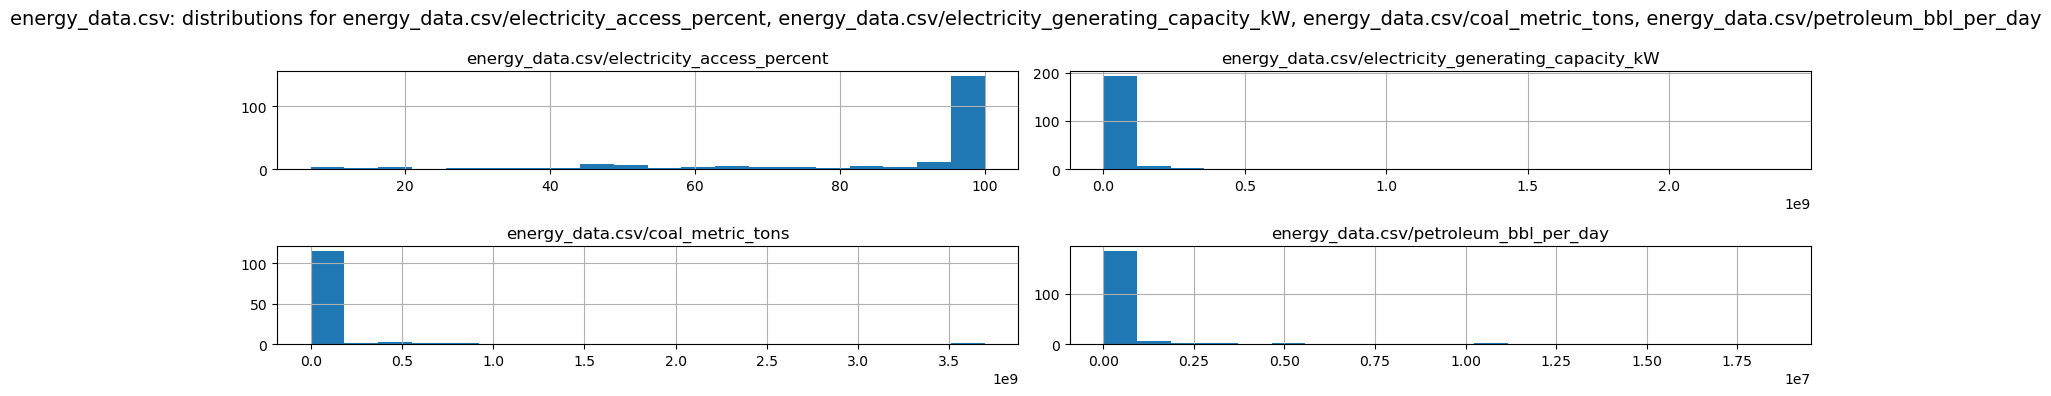

geography_data.csv — shape: (259, 16)


,geography_data.csv/Country,geography_data.csv/Geographic_Coordinates,geography_data.csv/Area_Total,geography_data.csv/Land_Area,geography_data.csv/Water_Area,geography_data.csv/Land_Boundaries,geography_data.csv/Coastline,geography_data.csv/Highest_Elevation,geography_data.csv/Lowest_Elevation,geography_data.csv/Forest_Land,geography_data.csv/Other_Land,geography_data.csv/Agricultural_Land,geography_data.csv/Arable_Land+(%25%25+of+Total+Agricultural+Land),geography_data.csv/Permanent_Crops+(%25%25+of+Total+Agricultural+Land),geography_data.csv/Permanent_Pasture+(%25%25+of+Total+Agricultural+Land),geography_data.csv/Irrigated_Land
0,AFGHANISTAN,"33 00 N, 65 00 E","652,230 sq km","652,230 sq km",0 sq km,"5,987 km",0 km,"7,492 m",258 m,1.8%,40.1%,58.1%,11.8%,0.3%,46%,"24,930 sq km"
1,AKROTIRI,"34 37 N, 32 58 E",123 sq km,None,None,48 km,56.3 km,None,None,None,None,None,None,None,None,None
2,ALBANIA,"41 00 N, 20 00 E","28,748 sq km","27,398 sq km","1,350 sq km",691 km,362 km,"2,764 m",0 m,28.8%,28.2%,42.8%,22.3%,3%,17.4%,"1,820 sq km"
3,ALGERIA,"28 00 N, 3 00 E","2,381,740 sq km","2,381,740 sq km",0 sq km,"6,734 km",998 km,"2,908 m",-40 m,0.8%,81.8%,17.4%,3.2%,0.4%,13.8%,"12,605 sq km"
4,AMERICAN SAMOA,"14 20 S, 170 00 W",224 sq km,224 sq km,0 sq km,0 km,116 km,964 m,0 m,75.5%,0%,24.5%,15%,9.5%,0%,0 sq km


fuck No numeric columns available for visualization.
government_and_civics_data.csv — shape: (253, 5)


,government_and_civics_data.csv/Country,government_and_civics_data.csv/Capital,government_and_civics_data.csv/Capital_Coordinates,government_and_civics_data.csv/Government_Type,government_and_civics_data.csv/Suffrage_Age
0,AFGHANISTAN,Kabul,"34 31 N, 69 11 E",Theocracy,18.0
1,AKROTIRI,Episkopi Cantonment,"34 40 N, 32 51 E",None,NaN
2,ALBANIA,Tirana,"41 19 N, 19 49 E",Republic,18.0
3,ALGERIA,Algiers,"36 45 N, 3 03 E",Republic,18.0
4,AMERICAN SAMOA,Pago Pago,"14 16 S, 170 42 W",Republic,18.0


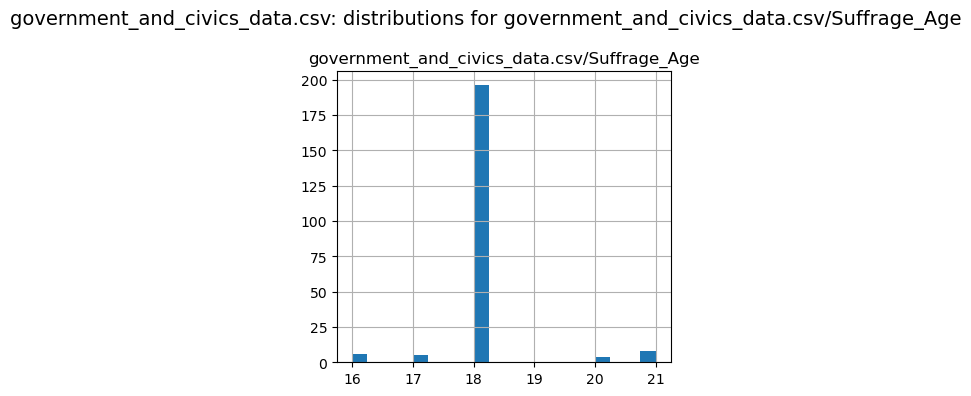

Croissant stream failed for transportation_data.csv (reason: An error occured during the streaming generation of the dataset, more specifically during the operation Read(transportation_data.csv_fileobject)). Using pandas.read_csv instead.
transportation_data.csv — shape: (259, 11)


,Country,airports_paved_runways_count,airports_unpaved_runways_count,heliports_count,roadways_km,railways_km,waterways_km,gas_pipelines_km,oil_pipelines_km,refined_products_pipelines_km,water_pipelines_km
0,AFGHANISTAN,29,17,1,34903,<NA>,1200,466,<NA>,<NA>,<NA>
1,AKROTIRI,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,ALBANIA,3,<NA>,<NA>,3945,424,41,498,<NA>,<NA>,<NA>
3,ALGERIA,67,82,4,104000,4020,<NA>,16415,7036,<NA>,<NA>
4,AMERICAN SAMOA,3,<NA>,<NA>,241,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


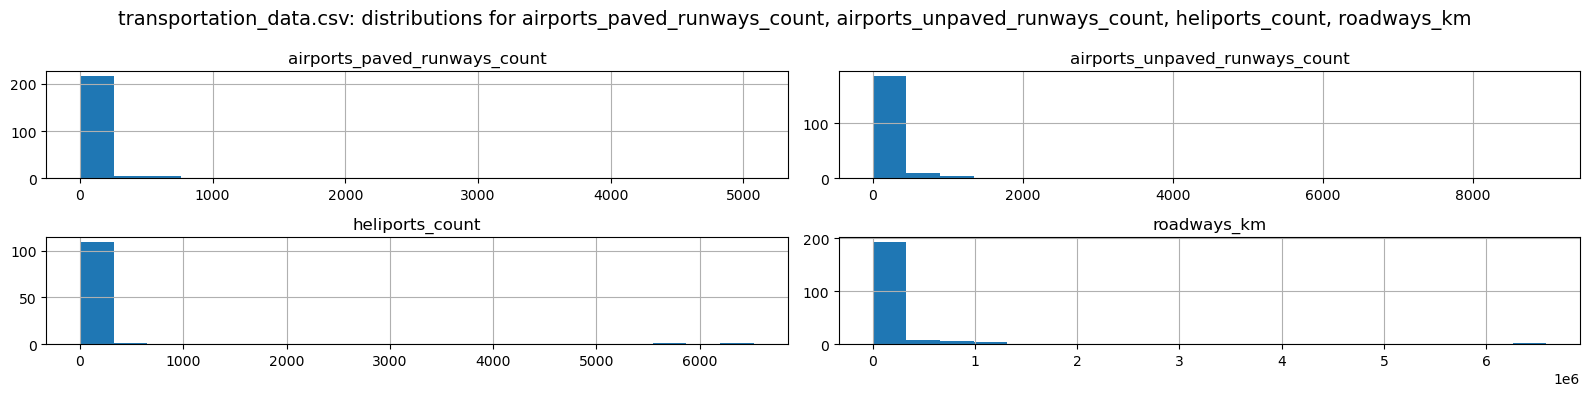

In [24]:
for record_id in record_set_ids:
    df = record_to_dataframe(croissant_dataset, record_id)
    show_dataframe_summary(df, title=record_id)
